In [201]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [3]:
# beta should be higher than c
n = 1000 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

alpha = -0.03    #  negative 0.003
beta  = -0.04    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = np.log(1/1e-2 - 1)    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 10
warm_up     = 5

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [4]:
ut  = utils.GraphUtils()
#graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation with MLE

In [ ]:
g = graphs[-1]
s = spectra[-1]

In [ ]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

In [ ]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [ ]:
initial_guess = [0,0,0]
est = estimator.MLEGraphModelEstimator(g)

a_hat, b_hat, s_hat = est.estimate_parameters_torch(initial_guess=initial_guess, learning_rate=0.001, max_iter=30)

In [ ]:
print(a_hat,b_hat,s_hat)
print(alpha, beta, sigma)

## Plot

In [ ]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


In [ ]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()

# Estimation with regression 

In [215]:
# beta should be higher than c
n = 1000 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

p = 1 / n
sigma = np.log( p / ( 1 - p ) )    # intercept the higher the harder for creating edges 6

# 10 is how many degrees i want in my graph with p = 0.5
# more factor -> less edges only the sigma will influence
factor = 0.10 # facotr * n is the degree that p=0.5
alpha = -sigma / (2 * (n-1))
beta  = -sigma / (2 * (n-1))

threshold   = 0.5
n_iteration = 100
warm_up     = 5

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [216]:
alpha, beta, sigma

(0.003456834223547825, 0.003456834223547825, -6.906754778648554)

In [218]:
graph_model = graph.GraphModel(n=n, p=p, alpha=alpha, beta=beta, sigma=sigma, threshold=threshold, n_iteration=n_iteration, warm_up=warm_up)
graphs, spec = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration, stability_window=3, degree_dist_threshold=0.05)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
KS Statistic: 0.02
KS Statistic: 0.042
Degree Distribution Stable: True
Graph Converged: True






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


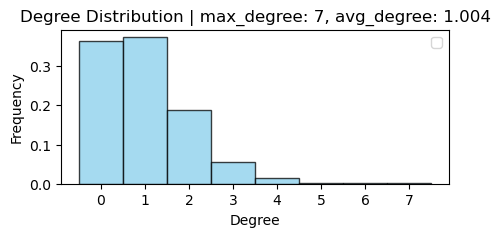

In [220]:
g = graphs[-1]
s = spec
G = nx.Graph(g)

ut = utils.GraphUtils()     
#fig = ut.plot_graph_and_spectrum(g, s, title='Graph and Spectrum', size=(10,5))
fig = ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))
#ut.save_graph_html(g, params_dict)

In [ ]:
est = estimator.LogitRegEstimator(g , p=0)

In [ ]:
params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0)
params, sigma, alpha, beta

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.126     
Date:               2024-04-18 12:53 AIC:              557.5126  
No. Observations:   4950             BIC:              577.0341  
Df Model:           2                Log-Likelihood:   -275.76   
Df Residuals:       4947             LL-Null:          -315.57   
Converged:          1.0000           LLR p-value:      5.1315e-18
No. Iterations:     27.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.5829     0.3356   -19.6175   0.0000   -7.2406   -5.9252
x1        0.7090     0.0921     7.6996   0.0000    0.5285    0.8895
x2        0.6349     0.1187     5.3476   0.0000    0.4022    0.8676



(array([-6.582895  ,  0.7090384 ,  0.63489864]),
 -4.59511985013459,
 0.023207676010780758,
 0.023207676010780758)

In [213]:
edges = list(G.edges())
non_edges = list(nx.non_edges(G))

# Combine edges and non-edges to form the dataset
data = edges + non_edges
labels = [1] * len(edges) + [0] * len(non_edges)

# Feature extraction: degrees of the vertices
#normalization = n - 1
normalization = 1
features = np.array([(G.degree(i) / normalization, G.degree(j) / normalization) for i, j in data])


In [214]:
len(edges) / len(non_edges)

0.011856091578086671

In [156]:
import statsmodels.api as sm
features = sm.add_constant(features)

In [71]:
len(np.unique(features))
#len(features)
l = pd.DataFrame(labels, columns=['label'])
f = pd.DataFrame(features, columns=['sigma','alpha','beta'])
dataset = pd.concat([l, f], axis=1)

x = dataset

In [72]:
x

,label,sigma,alpha,beta
0,1,1.0,2.0,2.0
1,1,1.0,2.0,2.0
2,1,1.0,5.0,3.0
3,1,1.0,5.0,1.0
4,1,1.0,5.0,6.0
...,...,...,...,...
124745,0,1.0,2.0,3.0
124746,0,1.0,2.0,6.0
124747,0,1.0,5.0,3.0
124748,0,1.0,5.0,6.0


In [73]:
# Logistic Regression Model using statsmodels with regularization
model = sm.Logit(x['label'].values, x.drop(columns='label').values)


result = model.fit_regularized(L1_wt=1, alpha=0, disp=0)

print(result.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.065     
Date:               2024-04-18 10:58 AIC:              6244.1933 
No. Observations:   124750           BIC:              6273.3955 
Df Model:           2                Log-Likelihood:   -3119.1   
Df Residuals:       124747           LL-Null:          -3335.7   
Converged:          1.0000           LLR p-value:      8.1246e-95
No. Iterations:     34.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -7.5990     0.1256   -60.4881   0.0000   -7.8452   -7.3528
x1        0.4384     0.0290    15.1230   0.0000    0.3816    0.4952
x2        0.4024     0.0259    15.5066   0.0000    0.3515    0.4533



# Multiple times

In [ ]:
n_runs = 20
params_list = []
for i in range(n_runs):
    graph_model = graph.GraphModel(n=n, p=p, alpha=alpha, beta=beta, sigma=sigma, threshold=threshold, n_iteration=n_iteration, warm_up=warm_up)
    graphs, _ = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration)
    g = graphs[-1]
    import gc
    del graphs
    gc.collect

    est = estimator.LogitRegEstimator2(g)
    params, pvalue = est.estimate_parameters()
    params_list.append(params)

    import pickle
    with open(f'runs/results_array2_{i}.pkl', 'wb') as f:
        pickle.dump(params_list, f)



iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 7
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 8
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 9
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
Degree Distribution Stable: True
Graph Converged: True






/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

LinAlgError: Singular matrix